1. Data Loading and Preprocessing

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load datasets
def load_datasets():
    data_folder = 'data'
    datasets = {
        'zhvi': 'zhvi.csv',
        'zori': 'zori.csv',
        'for_sale': 'for_sale.csv',
        'new_listings': 'new_listings.csv',
        'price_cuts': 'median-price-cuts.csv'
    }
    return {name: pd.read_csv(path) for name, path in datasets.items()}

# Reshape and filter datasets from 2018 onwards
def reshape_and_filter(df, date_start='2018-01-01', date_format='%Y-%m-%d'):
    df_long = pd.melt(df, id_vars='RegionName', var_name='Date', value_name='Value')
    df_long['Date'] = pd.to_datetime(df_long['Date'], format=date_format, errors='coerce')
    return df_long[df_long['Date'] >= pd.to_datetime(date_start)]

# Combine datasets on RegionName and Date
def combine_datasets(loaded_data):
    combined_df_list = []
    for name, df in loaded_data.items():
        reshaped_df = reshape_and_filter(df)
        reshaped_df.rename(columns={'Value': f'{name}_value'}, inplace=True)
        combined_df_list.append(reshaped_df)
    combined_data = combined_df_list[0]
    for df in combined_df_list[1:]:
        combined_data = pd.merge(combined_data, df, on=['RegionName', 'Date'], how='outer')
    return combined_data

# Load and combine data
loaded_data = load_datasets()
combined_data = combine_datasets(loaded_data)


2. Exploratory Data Analysis (EDA)

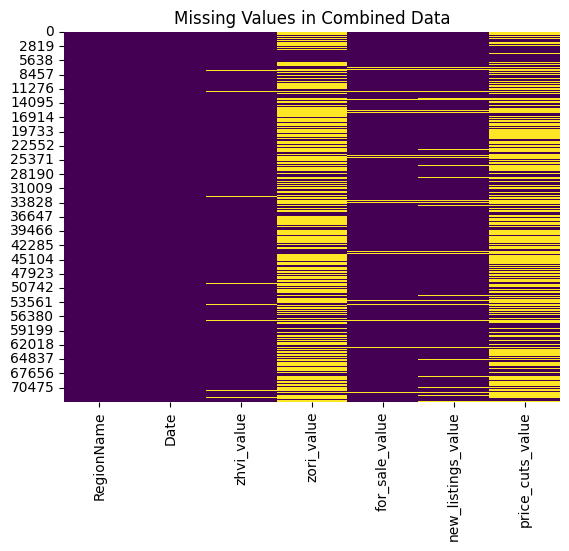

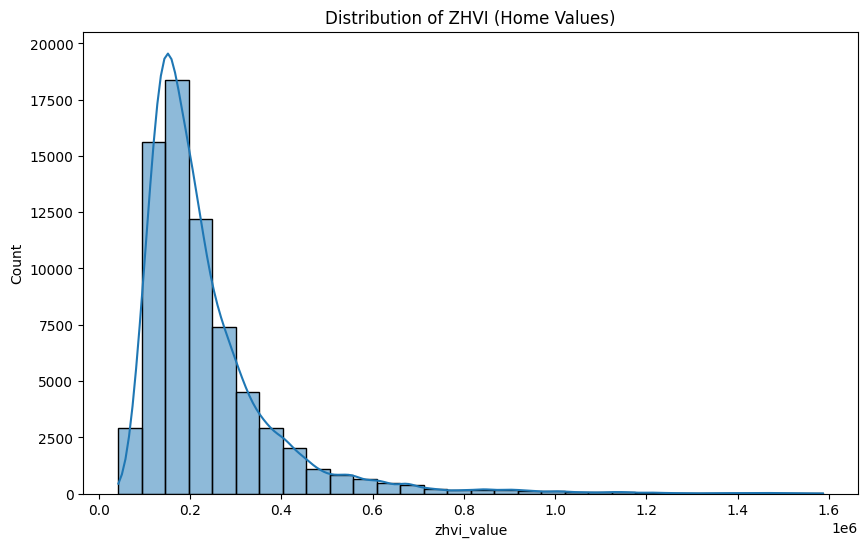


Summary statistics for zhvi_value:
count      70671.000000
unique     70671.000000
top       122539.157495
freq           1.000000
Name: zhvi_value, dtype: float64

Summary statistics for zori_value:
count     29745.0
unique    29739.0
top         907.5
freq          2.0
Name: zori_value, dtype: float64

Summary statistics for for_sale_value:
count     70265.0
unique     7116.0
top         108.0
freq        196.0
Name: for_sale_value, dtype: float64

Summary statistics for new_listings_value:
count     68123.0
unique     4251.0
top          28.0
freq        648.0
Name: new_listings_value, dtype: float64

Summary statistics for price_cuts_value:
count     31926.000000
unique    31817.000000
top           0.026469
freq          2.000000
Name: price_cuts_value, dtype: float64


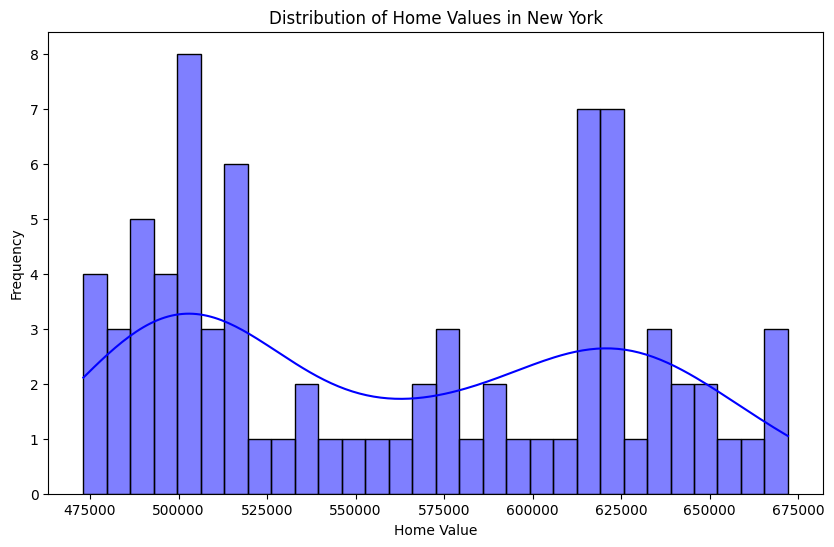

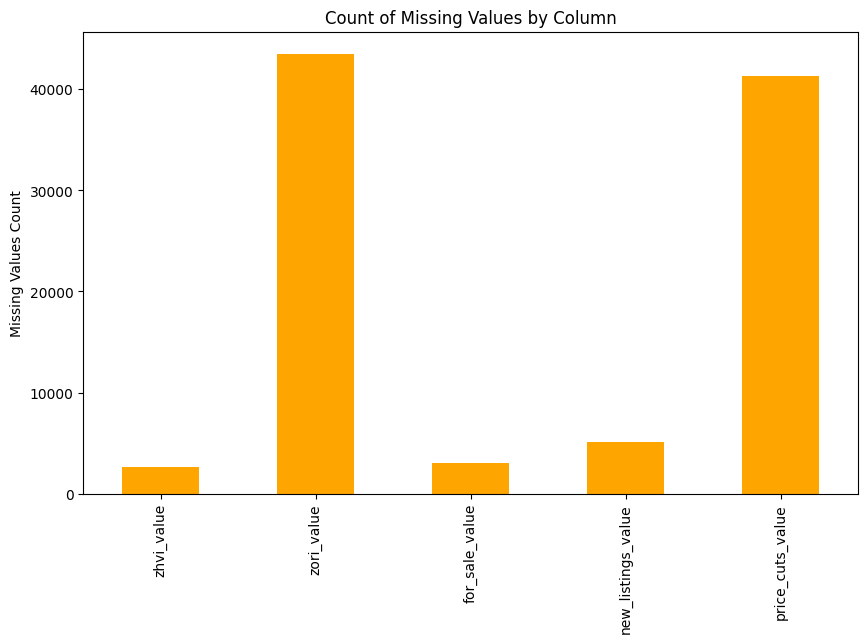

In [2]:
# Heatmap for missing data
def preprocess_and_visualize(combined_data):
    sns.heatmap(combined_data.isnull(), cbar=False, cmap='viridis')
    plt.title('Missing Values in Combined Data')
    plt.show()

    # Distribution of home values
    plt.figure(figsize=(10, 6))
    sns.histplot(combined_data['zhvi_value'].dropna(), kde=True, bins=30)
    plt.title('Distribution of ZHVI (Home Values)')
    plt.show()

# Call the function to visualize data
preprocess_and_visualize(combined_data)

# Define the columns for which you want to display summary statistics
value_columns = ['zhvi_value', 'zori_value', 'for_sale_value', 'new_listings_value', 
                 'price_cuts_value']

# Loop through each value column and display summary statistics
for col in value_columns:
    print(f"\nSummary statistics for {col}:")
    print(combined_data[col].describe())

# Distribution of home values by Region (e.g., New York)
ny_data = combined_data[combined_data['RegionName'].str.contains('New York', na=False)]

plt.figure(figsize=(10, 6))
sns.histplot(ny_data['zhvi_value'].dropna(), kde=True, bins=30, color='blue')
plt.title('Distribution of Home Values in New York')
plt.xlabel('Home Value')
plt.ylabel('Frequency')
plt.show()

# Visualize missing values by column
missing_data_count = combined_data.isnull().sum()
missing_data_count = missing_data_count[missing_data_count > 0]  # Only show columns with missing data

plt.figure(figsize=(10, 6))
missing_data_count.plot(kind='bar', color='orange')
plt.title('Count of Missing Values by Column')
plt.ylabel('Missing Values Count')
plt.show()



3. Model Training and Predictions (Machine Learning)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error

def get_user_input():
    # Ask what the user wants to predict
    while True:
        prediction_type = input("Select what you want to predict: (1) House Prices (ZHVI), (2) Rent Prices (ZORI): ")
        if prediction_type == '1':
            return 'zhvi_value'
        elif prediction_type == '2':
            return 'zori_value'
        else:
            print("Invalid selection. Please choose either 1 or 2.")

def get_region_input():
    # Ask for the region
    region = input("Enter the region you want to analyze (e.g., 'New York, NY'): ")
    return region

def validate_data(combined_data, features, target):
    missing_columns = [col for col in features + [target] if col not in combined_data.columns]
    if missing_columns:
        print(f"Missing columns: {missing_columns}")
        return False
    return True



# Function to train and compare models
def train_and_compare_models(X_train, X_test, y_train, y_test, model_results):
    while True:
        model_choice = input("Select a model: (1) Random Forest, (2) Ridge Regression, (3) Polynomial Regression, (4) Quit: ")
        if model_choice == '4':
            break
        model_results = train_and_predict_model(model_choice, X_train, X_test, y_train, y_test, model_results)

    # After quitting, plot all model comparisons
    if model_results:
        plot_model_comparisons(model_results, y_test)

# Function to plot all model predictions in one graph for comparison
def plot_model_comparisons(model_results, y_test):
    plt.figure(figsize=(10, 6))
    
    # Plot actual values
    plt.plot(y_test.values, label='Actual Values', color='blue')
    
    # Plot each model's predictions
    for model_name, y_pred in model_results.items():
        plt.plot(y_pred, label=f'{model_name} Predictions')

    plt.title("Comparison of Model Predictions")
    plt.xlabel("Data Points")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Function to train and predict model, modified to plot predictions
def train_and_predict_model(model_choice, X_train, X_test, y_train, y_test, model_results):
    if model_choice == '1':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model_name = 'Random Forest'
    elif model_choice == '2':
        model = Ridge(alpha=1.0)
        model_name = 'Ridge Regression'
    elif model_choice == '3':
        poly = PolynomialFeatures(degree=2)
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)
        model = LinearRegression()
        model_name = 'Polynomial Regression'
        model.fit(X_train_poly, y_train)
        y_pred = model.predict(X_test_poly)
    else:
        print("Invalid selection. Please select a valid model.")
        return model_results
    
    # Train and predict
    if model_choice in ['1', '2']:  # For models that don't need polynomial transformation
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # Store the predictions in model_results
    model_results[model_name] = y_pred

    # Plot actual vs predicted values for the current model
    plot_real_vs_predicted(y_test, y_pred, model_name)

    return model_results


# Plot real vs predicted values
def plot_real_vs_predicted(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(y_test)), y_test, label='Actual Values', color='blue')
    plt.plot(range(len(y_pred)), y_pred, label=f'{model_name} Predicted Values', color='red')
    plt.title(f"Real vs Predicted Values - {model_name}")
    plt.xlabel("Data Points")
    plt.ylabel("Values")
    plt.legend()
    plt.tight_layout()
    plt.show()


4. SARIMA and ARIMA Forecasting

In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

# Function to fit and forecast using SARIMA
def sarima_model(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
    model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
    return model.fit(disp=False)

# Function to fit and forecast using ARIMA
def arima_model(train_data, order=(1, 1, 1)):
    model = ARIMA(train_data, order=order)
    return model.fit()

# Forecast future values
def future_forecast(model_fit, steps=12):
    forecast = model_fit.get_forecast(steps=steps)
    return np.asarray(forecast.predicted_mean)

# Prepare data for time series models
def prepare_data(data, region, column):
    region_data = data[data['RegionName'] == region][column].dropna()
    if region_data.empty:
        print(f"No data found for region: {region}")
        return None, None
    region_data = pd.to_numeric(region_data, errors='coerce').dropna()
    region_data = region_data.values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(region_data)
    return scaled_data, scaler

# Inverse transform predictions
def inverse_transform_predictions(scaler, future_predictions_scaled):
    return scaler.inverse_transform(future_predictions_scaled.reshape(-1, 1))


5. SARIMA and ARIMA Comparison

Enter the region (e.g., 'New York, NY'):  New York, NY
Choose a target: 'zhvi_value' for home prices or 'zori_value' for rent prices:  zhvi_value
Enter the number of years into the future for forecasting:  3


/var/folders/ks/69lv6khn0zn4lp53hk7k2wqr0000gp/T/ipykernel_33720/1205580959.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  historical_dates = pd.date_range(start='2018-01', periods=len(train_data), freq='M')
/var/folders/ks/69lv6khn0zn4lp53hk7k2wqr0000gp/T/ipykernel_33720/1205580959.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=historical_dates[-1] + pd.DateOffset(months=1), periods=len(future_predictions_sarima), freq='M')


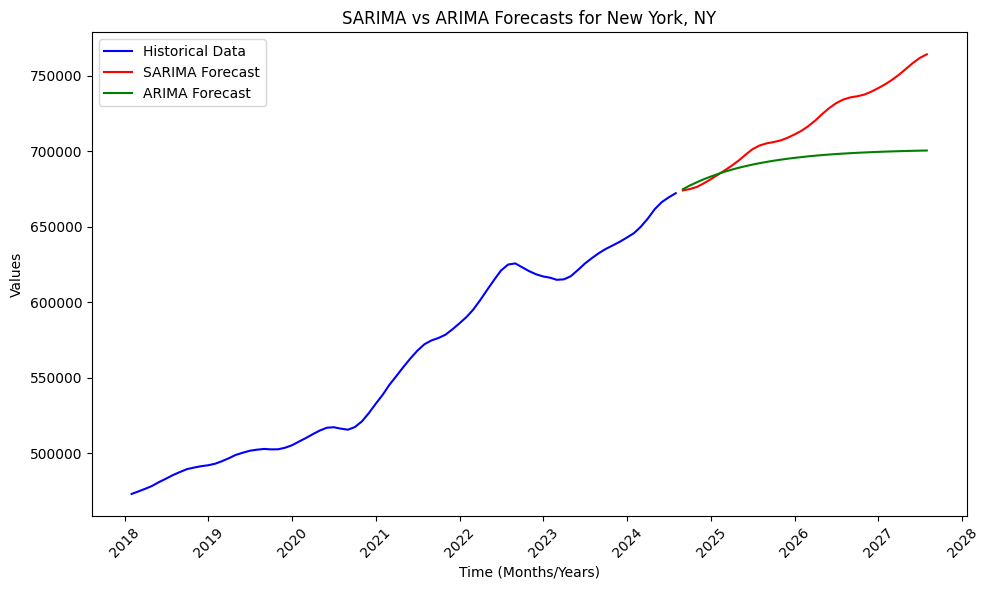

In [5]:
# Run SARIMA and ARIMA Comparison
def run_forecasting_comparison(data, region, target_column):
    region_data_scaled, scaler = prepare_data(data, region, target_column)
    if region_data_scaled is None:
        return

    forecast_years = int(input("Enter the number of years into the future for forecasting: "))
    steps = forecast_years * 12

    sarima_fit = sarima_model(region_data_scaled)
    future_predictions_sarima_scaled = future_forecast(sarima_fit, steps=steps)
    future_predictions_sarima = inverse_transform_predictions(scaler, future_predictions_sarima_scaled)

    arima_fit = arima_model(region_data_scaled)
    future_predictions_arima_scaled = future_forecast(arima_fit, steps=steps)
    future_predictions_arima = inverse_transform_predictions(scaler, future_predictions_arima_scaled)

    train_data = scaler.inverse_transform(region_data_scaled)
    plot_predictions(train_data, future_predictions_sarima, future_predictions_arima, region)

# Plot predictions
def plot_predictions(train_data, future_predictions_sarima, future_predictions_arima, region):
    plt.figure(figsize=(10, 6))
    historical_dates = pd.date_range(start='2018-01', periods=len(train_data), freq='M')
    forecast_dates = pd.date_range(start=historical_dates[-1] + pd.DateOffset(months=1), periods=len(future_predictions_sarima), freq='M')

    plt.plot(historical_dates, train_data, label='Historical Data', color='blue')
    plt.plot(forecast_dates, future_predictions_sarima, label='SARIMA Forecast', color='red')
    plt.plot(forecast_dates, future_predictions_arima, label='ARIMA Forecast', color='green')

    plt.title(f"SARIMA vs ARIMA Forecasts for {region}")
    plt.xlabel("Time (Months/Years)")
    plt.ylabel("Values")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage
region = input("Enter the region (e.g., 'New York, NY'): ")
target = input("Choose a target: 'zhvi_value' for home prices or 'zori_value' for rent prices: ")
run_forecasting_comparison(combined_data, region, target)


6. Main Function and User Input

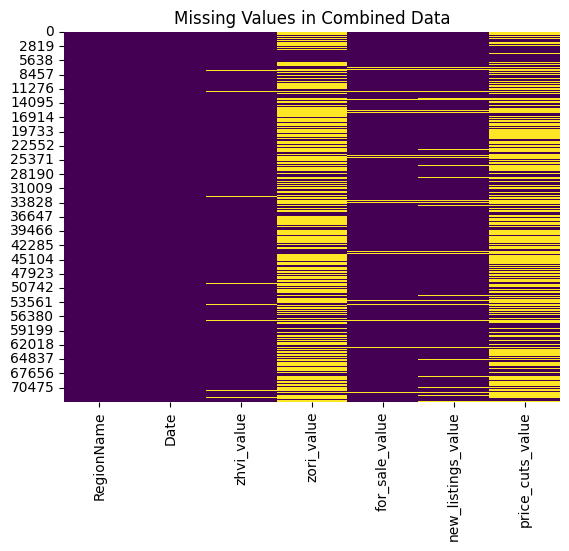

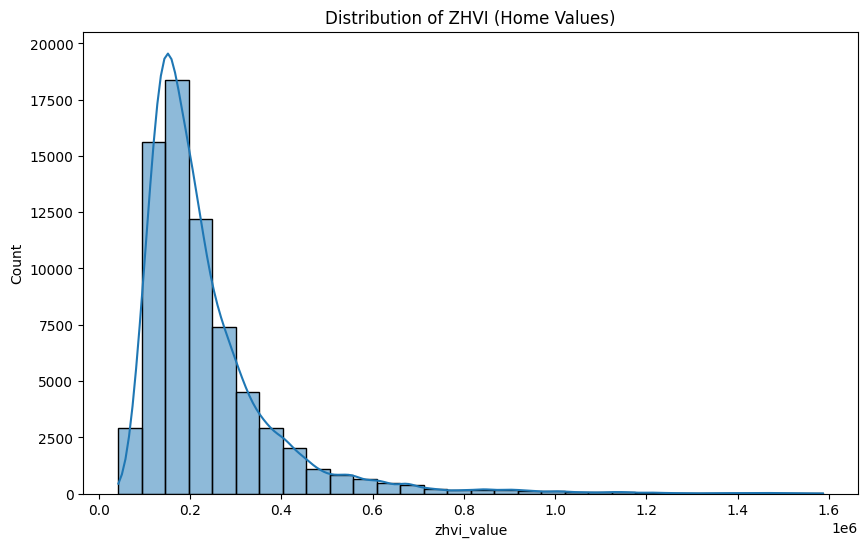

Select what you want to predict: (1) House Prices (ZHVI), (2) Rent Prices (ZORI):  2
Enter the region you want to analyze (e.g., 'New York, NY'):  Charlotte, NC
Select a model: (1) Random Forest, (2) Ridge Regression, (3) Polynomial Regression, (4) Quit:  1


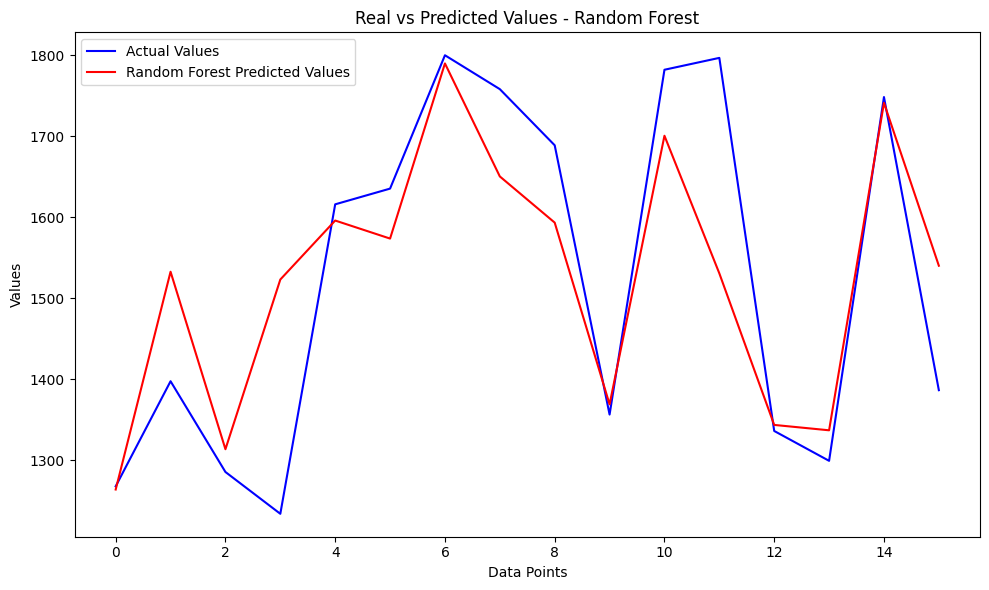

Select a model: (1) Random Forest, (2) Ridge Regression, (3) Polynomial Regression, (4) Quit:  4


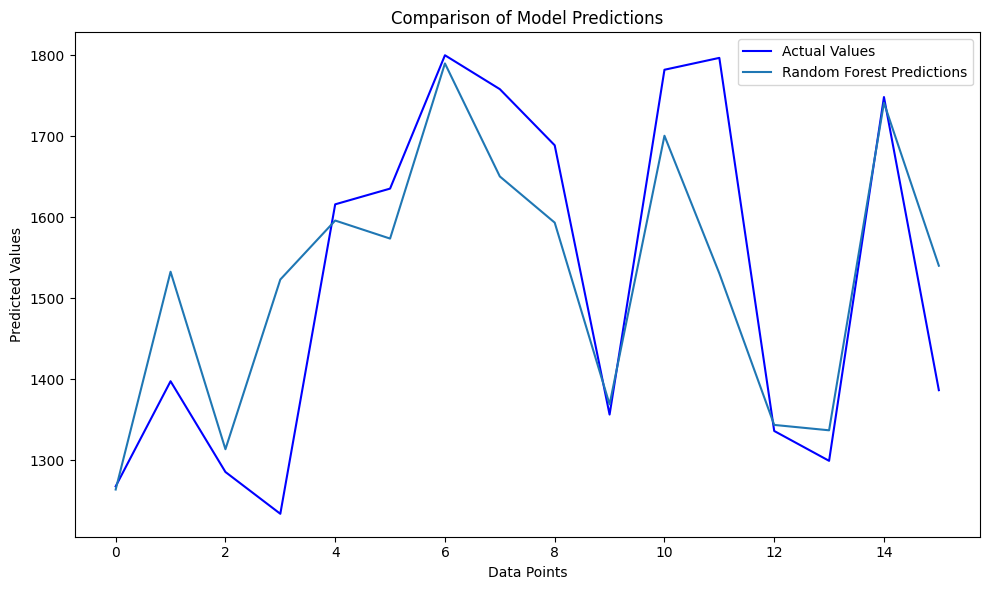

In [7]:
# Main function to manage the overall process
def main():
    # Load and combine data
    loaded_data = load_datasets()
    combined_data = combine_datasets(loaded_data)

    # EDA
    preprocess_and_visualize(combined_data)

    # Train/Test Split for Machine Learning Models
    target = get_user_input()
    region = get_region_input()
    features = ['for_sale_value', 'price_cuts_value', 'new_listings_value']

    region_data = combined_data[combined_data['RegionName'] == region].dropna(subset=features + [target])
    if region_data.empty:
        print(f"No data available for the region '{region}'")
        return

    X_train, X_test, y_train, y_test = train_test_split(region_data[features], region_data[target], test_size=0.2, random_state=42)

    # Dictionary to store results
    model_results = {}

    # Train and compare models
    train_and_compare_models(X_train, X_test, y_train, y_test, model_results)

if __name__ == "__main__":
    main()